Project 3

In [11]:
!rm -rf Deep-Learning
!git clone https://github.com/tmengel/Deep-Learning.git
!ls Deep-Learning/project3/
%cd Deep-Learning/project3
!pwd

Cloning into 'Deep-Learning'...
remote: Enumerating objects: 97745, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 97745 (delta 102), reused 198 (delta 100), pack-reused 97544
Receiving objects: 100% (97745/97745), 44.68 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (103/103), done.
Updating files: 100% (97720/97720), done.
fairface_label_train.csv  Project3.ipynb  train
fairface_label_val.csv	  project3.pdf	  val
/content/Deep-Learning/project3
/content/Deep-Learning/project3


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

age_labels = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','more than 70']
gender_labels = ['Female','Male']
race_labels= ['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian']
service_test_labels = ['True', 'False']
features = ['age','gender','race']
cat_labels = {
    'age': age_labels,
    'gender' : gender_labels,
    'race' : race_labels,
    # 'service_test' : service_test_labels
    }

# training_path = '/content/Deep-Learning/project3/fairface_label_train.csv'
# validation_path = '/content/Deep-Learning/project3/fairface_label_val.csv'
training_path = 'fairface_label_train.csv'
validation_path = 'fairface_label_val.csv'

def one_hot_encode(df,feature,labels):
    cats = df[feature].values
    one_hot = np.zeros((cats.size,labels.__len__()))
    for i in range(cats.size):
        one_hot[i][labels.index(cats[i])] = 1
    return one_hot

def one_hot_decode(one_hot,labels):
    return [labels[np.argmax(one_hot[i])] for i in range(one_hot.shape[0])]

def read_images(n, path):
    # read in csv file
    df = pd.read_csv(path)
    # sample n rows
    df = df.sample(n, random_state=42)
    # reset index
    df = df.reset_index(drop=True)
    # create empty list for images
    images = np.zeros((n, 32, 32, 1), dtype=np.uint8)
    # loop through each row and read in image file        
    for index, row in df.iterrows():
        image_path = f'/content/Deep-Learning/project3/{row["file"]}'
        image = Image.open(image_path)
        img = np.array(image)
        img = img.reshape(32,32,1)
        images[index] = img

    df = df.drop(columns=["file"])
    df['image_id'] = df.index   
    return df, images

def plot_images(df,images):
    # plot images
    fig, axs = plt.subplots(len(images)//5, 5, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(df.loc[i, "age"] + ", " + df.loc[i, "gender"] + ", " + df.loc[i, "race"])
    plt.show()
    
def min_max_scale_images(images):
    # Min-max scale each image
    images_min_max = np.zeros(images.shape)
    iter=0
    for i in images:
        ama = np.amax(i)
        ami = np.amin(i)
        i = (i - ami) / (ama - ami)
        images_min_max[iter] = i
        iter+=1
    return images_min_max

def count_categories(path):
    df = pd.read_csv(path)
    for column in df.columns:
        print(f"{column}: {df[column].nunique()} categories")

def load_data(n, path,plot=False):
    df, images = read_images(n, path)
    images = min_max_scale_images(images)
    if plot:
        plot_images(df,images)
    
    
    # One-hot encode labels
    one_hot = {}
    labels = {}
    for feature in features:
        one_hot[feature] = one_hot_encode(df, feature, cat_labels[feature])
        labels[feature] = one_hot_decode(one_hot[feature], cat_labels[feature])
    
    return images, one_hot, labels

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # plot training and validation loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['train', 'val'], loc='best')

    plt.show()
    
def evaluate_model(model, images_test, one_hot_test, labels_test, target):
    # Evaluate the model on test data
    test_loss, test_acc = model.evaluate(images_test, one_hot_test[target])

    # Get predictions for the test data
    test_pred_one_hot = model.predict(images_test)
    test_pred_labels = one_hot_decode(test_pred_one_hot, cat_labels[target])

    # Create the confusion matrix
    cm = confusion_matrix(labels_test[target], test_pred_labels, labels=cat_labels[target])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[target], yticklabels=cat_labels[target])
    plt.xlabel('Predicted labels')
    ax = plt.gca()
    ax.invert_yaxis()
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    print('Final classification accuracy:', test_acc)
    
def plot_multi_history(history, features):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    # plot training and validation loss
    axs[0][0].plot(history.history[f'{features[0]}_output_loss'])
    axs[0][0].plot(history.history[f'val_{features[0]}_output_loss'])
    axs[0][0].set_title(f'{features[0]} Loss')
    axs[0][0].set_xlabel('Epoch')
    axs[0][0].set_ylabel('Loss')
    axs[0][0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[0][1].plot(history.history[f'{features[0]}_output_accuracy'])
    axs[0][1].plot(history.history[f'val_{features[0]}_output_accuracy'])
    axs[0][1].set_title(f'{features[0]} Accuracy')
    axs[0][1].set_xlabel('Epoch')
    axs[0][1].set_ylabel('Accuracy')
    axs[0][1].legend(['train', 'val'], loc='best')
    
    axs[1][0].plot(history.history[f'{features[1]}_output_loss'])
    axs[1][0].plot(history.history[f'val_{features[1]}_output_loss'])
    axs[1][0].set_title(f'{features[1]} Loss')
    axs[1][0].set_xlabel('Epoch')
    axs[1][0].set_ylabel('Loss')
    axs[1][0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[1][1].plot(history.history[f'{features[1]}_output_accuracy'])
    axs[1][1].plot(history.history[f'val_{features[1]}_output_accuracy'])
    axs[1][1].set_title(f'{features[1]} Accuracy')
    axs[1][1].set_xlabel('Epoch')
    axs[1][1].set_ylabel('Accuracy')
    axs[1][1].legend(['train', 'val'], loc='best')
    

    plt.show()
    
def evaluate_multi_model(model, images_test, one_hot_test, labels_test, targets):
    evaluation = model.evaluate(images_test, [one_hot_test[targets[0]], one_hot_test[targets[1]]], verbose=0)
    print(f'Final classification accuracies: {targets[0]} {evaluation[3]}, {targets[1]} {evaluation[4]}')

    test_pred_one_hot_feature1, test_pred_one_hot_feature2  = model.predict(images_test)
    test_pred_labels_feature1 = one_hot_decode(test_pred_one_hot_feature1, cat_labels[targets[0]])
    test_pred_labels_feature2 = one_hot_decode(test_pred_one_hot_feature2, cat_labels[targets[1]])

    cm_feature1 = confusion_matrix(labels_test[targets[0]], test_pred_labels_feature1, labels=cat_labels[targets[0]])
    cm_feature2 = confusion_matrix(labels_test[targets[1]], test_pred_labels_feature2, labels=cat_labels[targets[1]])

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0] = sns.heatmap(cm_feature1, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[targets[0]], yticklabels=cat_labels[targets[0]], ax=axs[0])
    axs[0].set_xlabel(f'Predicted {targets[0]} labels')
    axs[0].set_ylabel(f'True {targets[0]} labels')
    axs[0].set_title(f'{targets[0]} Confusion matrix')
    axs[0].invert_yaxis()
    axs[1] = sns.heatmap(cm_feature2, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[targets[1]], yticklabels=cat_labels[targets[1]], ax=axs[1])
    axs[1].set_xlabel(f'Predicted {targets[1]} labels')
    axs[1].set_ylabel(f'True {targets[1]} labels')
    axs[1].set_title(f'{targets[1]} Confusion matrix')
    axs[1].invert_yaxis()

    # plt.title('Confusion matrices')
    plt.show()


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate, Dropout
from tensorflow.keras.models import Model

def FullyConnectedNetwork(output_size):
    return Sequential([
            Flatten(input_shape=(32, 32, 1)),
            Dense(1024, activation='tanh'),
            Dense(512, activation='sigmoid'),
            Dense(100, activation='relu'),
            Dense(output_size, activation='softmax')
        ])
    
def SmallCNN(output_size):
    return Sequential([
            Conv2D(40,input_shape=(32,32,1),kernel_size=(5,5),strides=1,padding='valid', activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Flatten(),
            Dense(100,activation='relu'),
            Dense(output_size,activation='softmax')
        ])
    
def CustomCNN(output_size):
    return Sequential([
        Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(output_size,activation='softmax')
    ])

def MultiTaskCNN(output_size, features):
    # Define inputs
    inputs = Input(shape=(32, 32, 1))

    # Convolutional layers for feature1 branch
    feature1_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',)(inputs)
    feature1_pool1 = MaxPooling2D(pool_size=(2, 2))(feature1_conv1)
    feature1_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature1_pool1)
    feature1_pool2 = MaxPooling2D(pool_size=(2, 2))(feature1_conv2)

    # Convolutional layers for feature2 branch
    feature2_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    feature2_pool1 = MaxPooling2D(pool_size=(2, 2))(feature2_conv1)
    feature2_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature2_pool1)
    feature2_pool2 = MaxPooling2D(pool_size=(2, 2))(feature2_conv2)

    # Flatten and concatenate branches
    feature1_flatten = Flatten()(feature1_pool2)
    feature2_flatten = Flatten()(feature2_pool2)
    merged = concatenate([feature1_flatten, feature2_flatten])

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(merged)
    feature1_dense2 = Dense(64, activation='relu')(dense1)
    feature1_output = Dense(output_size[0], activation='softmax', name=f'{features[0]}_output')(feature1_dense2)
    feature2_dense2 = Dense(64, activation='relu')(dense1)
    feature2_output = Dense(output_size[1], activation='softmax', name=f'{features[1]}_output')(feature2_dense2)

    return Model(inputs=inputs, outputs=[feature1_output, feature2_output])   

def do_task(target, model, ntrain, nval, loss, optimizer, epochs, batch_size, metrics):
    
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)
    
    # Create the model   
    output_size = len(cat_labels[target])
    if model == 'FullyConnectedNetwork':
        model = FullyConnectedNetwork(output_size)
    elif model == 'SmallCNN':
        model = SmallCNN(output_size)
    elif model == 'CustomCNN':
        model = CustomCNN(output_size)
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    
    # Train the model
    history = model.fit(images_train, one_hot_train[target], epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Plot the training and validation loss and accuracy
    plot_history(history)
    
    # Evaluate the model on test data
    evaluate_model(model, images_test, one_hot_test, labels_test, target) 

def do_multi_task(targets, model, ntrain, nval, loss, optimizer, epochs, batch_size, metrics):
    
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)

    # Create the model   
    output_size = [len(cat_labels[target]) for target in targets]
    model = MultiTaskCNN(output_size, targets)       
    model.compile(optimizer=optimizer,
                    loss = {f'{targets[0]}_output': loss, f'{targets[1]}_output': loss},
                    metrics=metrics)
    model.summary()

    # Train the model
    history = model.fit(images_train, {f'{targets[0]}_output': one_hot_train[targets[0]], f'{targets[1]}_output': one_hot_train[targets[1]]},
        epochs=epochs, batch_size=batch_size, validation_split=0.2)

    plot_multi_history(history, targets)

    evaluate_multi_model(model, images_test, one_hot_test, labels_test, targets) 

Preview Dataset

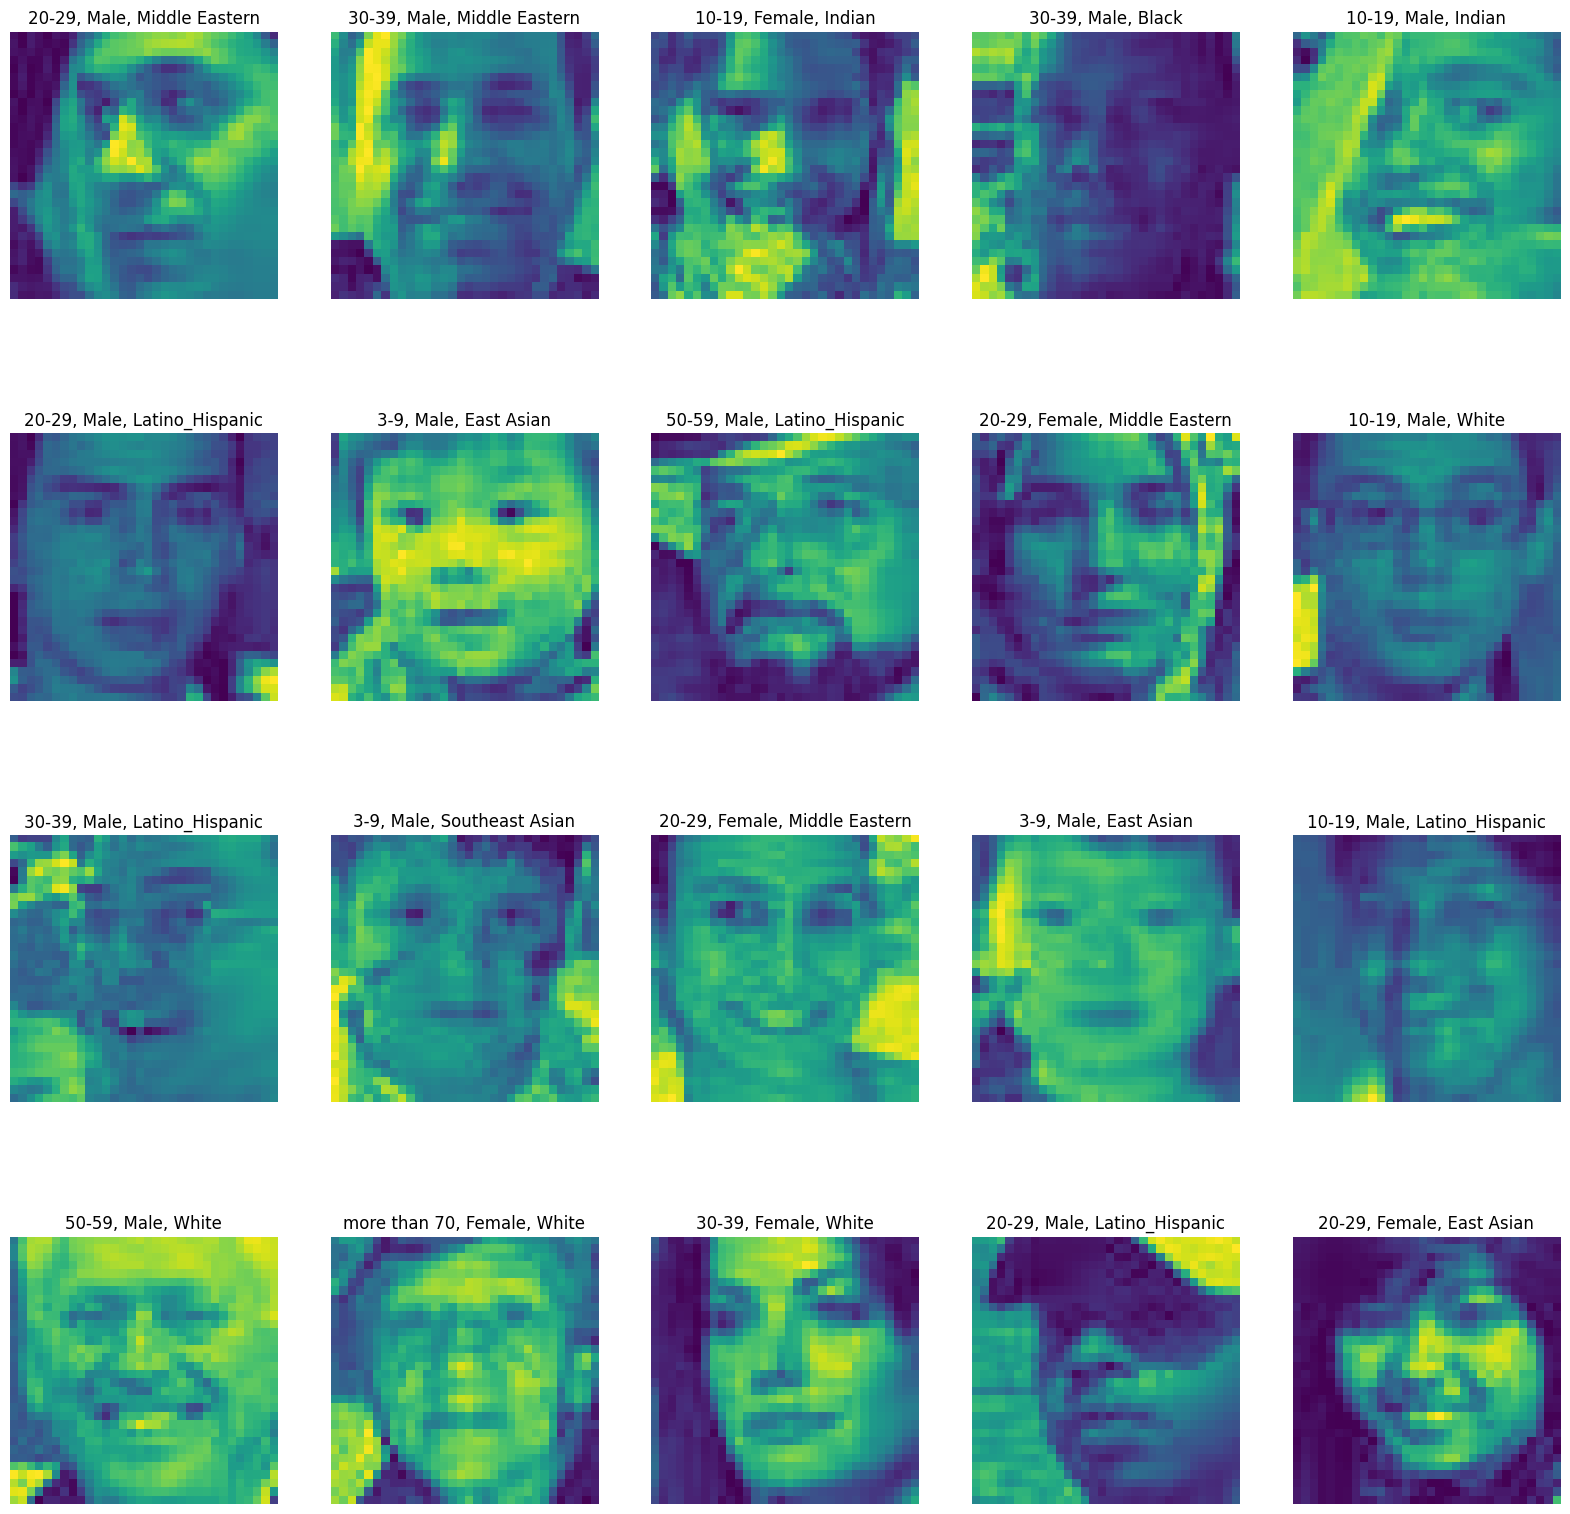

In [7]:
images_train, one_hot_train, labels_train = load_data(20, training_path, plot=True)

Task 1: Fully Connected Neural Network

In [9]:
do_task(target='age', model="FullyConnectedNetwork", ntrain=86744, nval=10954, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 100)               51300     
                                                                 
 dense_7 (Dense)             (None, 9)                 909       
                                                                 
Total params: 1,626,609
Trainable params: 1,626,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2169/2169 [=====================

KeyboardInterrupt: ignored

In [ ]:
do_task(target='gender', model="FullyConnectedNetwork", ntrain=86744, nval=10954, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Task 2: Small Convolutional Neural Network

In [ ]:
do_task(target='age', model="SmallCNN", ntrain=86744, nval=10954, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

In [ ]:
do_task(target='gender', model="SmallCNN", ntrain=86744, nval=10954, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Task 3: Your own Convolutional Neural Network

In [ ]:
do_task(target='age', model="CustomCNN", ntrain=86744, nval=10954, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

In [ ]:
do_task(target='gender', model="CustomCNN", ntrain=86744, nval=10954, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Task 4: Your own Convolutional Neural Network on both Tasks Simultaneously

In [12]:
do_multi_task(targets=['age','gender'], model="MultiTaskCNN", ntrain=86744, nval=10954, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

KeyboardInterrupt: ignored

In [20]:
!git config --global user.email "tmengel@vols.utk.edu"
!git config --global user.name "tmengel"
!git status
!git add Project3.ipynb
!git commit -m "Added output from google collab"
!git push

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
